<a href="https://colab.research.google.com/github/gyunini/2023-AI-Intensive-Challange/blob/main/2023_AI_Intensive_Challange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


cuda:0
(50000, 32, 32, 3)
[23 81 72 ... 35 56 31]
(32, 32, 3)


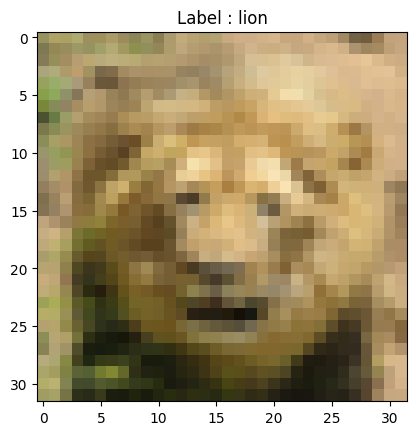

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

data_dir = '/content/drive/MyDrive/ColabNotebooks/집중교육1_CV실습/2023-ai-challenge'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

trainset = 'trainset.npy' # 50,000개의 데이터,
trainlabel = 'trainlabel.npy'
testset = 'testset.npy'  # 10,000개의 데이터
sample_submission = 'sample_submission.csv'
trainset = np.load(os.path.join(data_dir, trainset))
trainlabel = np.load(os.path.join(data_dir, trainlabel))
testset = np.load(os.path.join(data_dir, testset))

CIFAR100_CLASSES = sorted(['beaver', 'dolphin', 'otter', 'seal', 'whale',  # aquatic mammals
                           'aquarium' 'fish', 'flatfish', 'ray', 'shark', 'trout',  # fish
                           'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', # flowers
                           'bottles', 'bowls', 'cans', 'cups', 'plates', # food containers
                           'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', # fruit and vegetables
                           'clock', 'computer' 'keyboard', 'lamp', 'telephone', 'television', # household electrical devices
                           'bed', 'chair', 'couch', 'table', 'wardrobe', # household furniture
                           'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', # insects
                           'bear', 'leopard', 'lion', 'tiger', 'wolf', # large carnivores
                           'bridge', 'castle', 'house', 'road', 'skyscraper', # large man-made outdoor things
                           'cloud', 'forest', 'mountain', 'plain', 'sea', # large natural outdoor scenes
                           'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', # large omnivores and herbivores
                           'fox', 'porcupine', 'possum', 'raccoon', 'skunk', # medium-sized mammals
                           'crab', 'lobster', 'snail', 'spider', 'worm', # non-insect invertebrates
                           'baby', 'boy', 'girl', 'man', 'woman', # people
                           'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', # reptiles
                           'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', # small mammals
                           'maple', 'oak', 'palm', 'pine', 'willow', # trees
                           'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', # vehicles 1
                           'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor' # vehicles 2
                          ])


config = {'Cifar100_stats': [[0.5071, 0.4867, 0.4408],
                            [0.2675, 0.2565, 0.2761]],
          'batch_size'  : 256,
          'worker'      : 2,
          'epochs'      : 400,
          'momentum'    : 0.9,
          'lr_decay'    : 0.05,
          'SGD_lr'      : 0.01,
          'Adam_lr'     : 0.005,
          }

print(trainset.shape)
# print(trainset[0])
print(trainlabel)
print(trainset[6].shape)
plt.imshow(trainset[6], interpolation='nearest') # 맨 앞의 채널을 날려줘야 이차원 이미지를 보여줄 수 있음
plt.title(f'Label : {CIFAR100_CLASSES[trainlabel[6]]}')
plt.show()

(32, 32, 3)


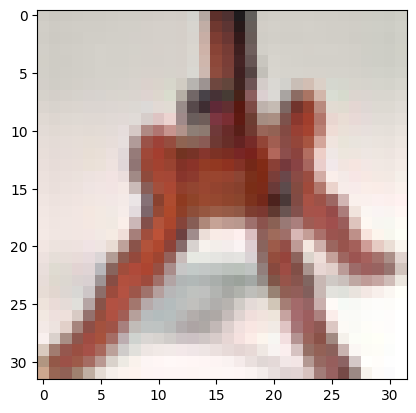

In [ ]:
print(testset[6].shape)
plt.imshow(testset[51], interpolation='nearest') # 맨 앞의 채널을 날려줘야 이차원 이미지를 보여줄 수 있음
plt.show()

In [ ]:
'''MobileNetV3 in PyTorch.

See the paper "Inverted Residuals and Linear Bottlenecks:
Mobile Networks for Classification, Detection and Segmentation" for more details.
'''
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init



class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out


class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out


class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        expand_size =  max(in_size // reduction, 8)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, expand_size, kernel_size=1, bias=False),
            nn.BatchNorm2d(expand_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(expand_size, in_size, kernel_size=1, bias=False),
            nn.Hardsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, act, se, stride):
        super(Block, self).__init__()
        self.stride = stride

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.act1 = act(inplace=True)

        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.act2 = act(inplace=True)
        self.se = SeModule(expand_size) if se else nn.Identity()

        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)
        self.act3 = act(inplace=True)

        self.skip = None
        if stride == 1 and in_size != out_size:
            self.skip = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_size)
            )

        if stride == 2 and in_size != out_size:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels=in_size, out_channels=in_size, kernel_size=3, groups=in_size, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(in_size),
                nn.Conv2d(in_size, out_size, kernel_size=1, bias=True),
                nn.BatchNorm2d(out_size)
            )

        if stride == 2 and in_size == out_size:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels=in_size, out_channels=out_size, kernel_size=3, groups=in_size, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_size)
            )

    def forward(self, x):
        skip = x

        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        out = self.se(out)
        out = self.bn3(self.conv3(out))

        if self.skip is not None:
            skip = self.skip(skip)
        return self.act3(out + skip)



class MobileNetV3_Small(nn.Module):
    def __init__(self, num_classes=100, act=nn.Hardswish):
        super(MobileNetV3_Small, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.hs1 = act(inplace=True)

        # self.bneck = nn.Sequential(
        #     Block(3, 16, 16, 16, nn.ReLU, True, 2),
        #     Block(3, 16, 64, 24, nn.ReLU, False, 1),
        #     Block(3, 24, 88, 24, nn.ReLU, False, 1),
        #     Block(5, 24, 120, 40, act, True, 2),
        #     Block(5, 40, 120, 80, act, True, 1),
        #     Block(5, 80, 90, 96, act, True, 1),
        # )
        # self.bneck = nn.Sequential(
        #     Block(3, 16, 16, 16, nn.ReLU, True, 2),
        #     Block(3, 16, 64, 24, nn.ReLU, False, 1),
        #     Block(3, 24, 120, 40, nn.ReLU, False, 1),
        #     Block(5, 40, 120, 80, act, True, 2),
        #     Block(5, 80, 120, 112, act, True, 1),
        #     # Block(5, 80, 90, 96, act, True, 1),
        # )
        self.bneck = nn.Sequential(
            Block(3, 16, 16, 16, nn.ReLU, True, 2),
            Block(3, 16, 64, 24, nn.ReLU, False, 1),
            Block(3, 24, 120, 24, nn.ReLU, False, 1),
            Block(5, 24, 144, 40, act, True, 2),
            Block(5, 40, 120, 65, act, True, 1),
            Block(5, 65, 80, 96, act, True, 1),
        )


        # self.conv2 = nn.Conv2d(112, 256, kernel_size=1, stride=1, padding=0, bias=False)
        # self.bn2 = nn.BatchNorm2d(256)
        # self.hs2 = act(inplace=True)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # self.linear3 = nn.Linear(576, 1280, bias=False)
        # self.bn3 = nn.BatchNorm1d(96)
        # self.hs3 = act(inplace=True)
        # self.drop = nn.Dropout(0.2)
        self.linear4 = nn.Linear(96, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)

        # out = self.hs2(self.bn2(self.conv2(out)))
        x = self.gap(out)
        x = x.view(x.size(0), -1)
        # out = self.gap(out).flatten(1)
        # out = self.drop(self.hs3(self.bn3(self.linear3(out))))
        # x = self.bn3(x)
        return self.linear4(x)

In [ ]:
mobilenetv3_small = MobileNetV3_Small()
mobilenetv3_small.to(device)
summary(mobilenetv3_small, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         Hardswish-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]             256
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 16, 16]             144
       BatchNorm2d-8           [-1, 16, 16, 16]              32
              ReLU-9           [-1, 16, 16, 16]               0
AdaptiveAvgPool2d-10             [-1, 16, 1, 1]               0
           Conv2d-11              [-1, 8, 1, 1]             128
      BatchNorm2d-12              [-1, 8, 1, 1]              16
             ReLU-13              [-1, 8, 1, 1]               0
           Conv2d-14             [-1, 1

In [ ]:
class CIFAR100Dataset(Dataset): # 커스텀 데이터셋 구성을 위해 Dataset 상속 후 __init__, __len__, __getitem__ 오버라이딩
    """custom cifar100 dataset."""

    def __init__(self, initial_data, label, transform=None):
        """
        Args:
            initial_data: all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.feature = initial_data
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        sample = self.feature[idx]
        label = self.label[idx]
        # label = torch.from_numpy(np.array(label))
        if self.transform: # transform 있으면 적용
            sample = self.transform(sample)
        return sample, label

In [ ]:
trainset = CIFAR100Dataset(initial_data=trainset, label=trainlabel, transform=transforms.Compose([ # 위의 코드와는 다르게 transform이 파라미터로 들어감
                                               transforms.ToTensor(),
                                              #  transforms.Resize(256, antialias=False),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ColorJitter(brightness=0.5),
                                               transforms.Normalize(*config['Cifar100_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
                                           ]))

In [ ]:
# Data Loader
trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle = True, num_workers = config['worker'])

In [ ]:
# path = os.path.join(data_dir, 'mobilenetv3_small_plz_1014.pth')
# mobilenetv3_small.load_state_dict(torch.load(path))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=mobilenetv3_small.parameters(), lr = config['Adam_lr'], weight_decay=config['lr_decay'])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, config['Adam_lr'], total_steps=config['epochs'] * len(trainloader))

In [ ]:
from sklearn.metrics import accuracy_score
import time


import torch.nn.functional as F

def onehot(label, n_classes):
    return torch.zeros(label.size(0), n_classes).to(device).scatter_(
        1, label.view(-1, 1), 1)


def mixup(data, targets, alpha=1.0, n_classes=100):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    targets = onehot(targets, n_classes)
    targets2 = onehot(targets2, n_classes)

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)]).to(device)
    data = data * lam + data2 * (1 - lam)
    targets = targets * lam + targets2 * (1 - lam)

    return data, targets

def mixup_loss(input, target, size_average=True):
    input = F.log_softmax(input, dim=1)
    loss = -torch.sum(input * target) # crossentropy_loss
    if size_average:
        return loss / input.size(0)
    else:
        return loss

# training
for epoch in range(400):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)
        inputs, labels = mixup(inputs, labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = mobilenetv3_small(inputs)
        # loss = criterion(output, labels)
        loss = mixup_loss(output, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()

        # train accuracy 계산
        # _, predicted = torch.max(output.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time
        time_taken = str(time_taken/60).split('.')

    # train_accuracy = 100 * correct / total
    # print('Epoch: {}/{}, train_loss: {:.4f}, train_accuracy: {:.2f}%, time:{}m {}s'.format(epoch + 1, 100, running_loss / len(trainset), train_accuracy, time_taken[0], time_taken[1][:2]))
    print('Epoch: {}/{}, train_loss: {:.4f}, time:{}m {}s'.format(epoch + 1, 400, running_loss / len(trainset), time_taken[0], time_taken[1][:2]))

Epoch: 1/400, train_loss: 0.0177, time:0m 18s
Epoch: 2/400, train_loss: 0.0171, time:0m 16s
Epoch: 3/400, train_loss: 0.0165, time:0m 16s
Epoch: 4/400, train_loss: 0.0161, time:0m 17s
Epoch: 5/400, train_loss: 0.0158, time:0m 17s
Epoch: 6/400, train_loss: 0.0156, time:0m 17s
Epoch: 7/400, train_loss: 0.0152, time:0m 17s
Epoch: 8/400, train_loss: 0.0152, time:0m 17s
Epoch: 9/400, train_loss: 0.0148, time:0m 17s
Epoch: 10/400, train_loss: 0.0149, time:0m 17s
Epoch: 11/400, train_loss: 0.0147, time:0m 17s
Epoch: 12/400, train_loss: 0.0145, time:0m 17s
Epoch: 13/400, train_loss: 0.0144, time:0m 17s
Epoch: 14/400, train_loss: 0.0141, time:0m 17s
Epoch: 15/400, train_loss: 0.0140, time:0m 17s
Epoch: 16/400, train_loss: 0.0138, time:0m 17s
Epoch: 17/400, train_loss: 0.0137, time:0m 17s
Epoch: 18/400, train_loss: 0.0136, time:0m 17s
Epoch: 19/400, train_loss: 0.0135, time:0m 17s
Epoch: 20/400, train_loss: 0.0136, time:0m 17s
Epoch: 21/400, train_loss: 0.0132, time:0m 17s
Epoch: 22/400, train_l

In [ ]:
import torch
# save train model
path = os.path.join(data_dir, 'mobilenetv3_small_tue13.pth')
torch.save(mobilenetv3_small.state_dict(), path)

In [ ]:
class TestDataset(Dataset): # 커스텀 데이터셋 구성을 위해 Dataset 상속 후 __init__, __len__, __getitem__ 오버라이딩
    def __init__(self, initial_data, transform=None):
        self.feature = initial_data
        self.transform = transform

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        sample = self.feature[idx]
        if self.transform: # transform 있으면 적용
            sample = self.transform(sample)
        return sample

test = TestDataset(initial_data=testset, transform=transforms.Compose([ # 위의 코드와는 다르게 transform이 파라미터로 들어감
                                               transforms.ToTensor(),
                                              #  transforms.Resize(256, antialias=False),
                                               transforms.Normalize(*config['Cifar100_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
                                           ]))

test_loader = DataLoader(test, batch_size = config['batch_size'], shuffle = False, num_workers = config['worker'])

In [ ]:
from pickleshare import Path
import csv
path = os.path.join(data_dir, 'tue13.csv')
#Testing Accuracy
correct = 0
data = [["id_idx", "label"]]
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        images = test_data.to(device)
        outputs = mobilenetv3_small(images)
        _, predicted = torch.max(outputs.data, 1)
        for index, batch_data in enumerate(predicted):
          data.append([i*256 + index, batch_data.item()])

    with open(path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # 데이터를 CSV 파일로 쓰기
        for row in data:
            writer.writerow(row)